# Text classification

# Sentiment Analysis

<video controls src="cartoon.m4v" type="video/mp4" />

# Overview

In order to train a machine learning model to classify text, we need:
1. a way to preprocess text (check!)
2. a way to represent each text as vector input (check)
3. a label for each text, represented as number
4. a model to learn  a function $f(input) = label$
5. a way to evaluate how well the model works


In [165]:
import pandas as pd

data = pd.read_csv('sa_train.csv')
print(len(data), data['output'].unique())
data.head(2)

1800 ['neg' 'pos']


,input,output
0,shakespeare in love is quite possibly the most...,neg
1,wizards is an animated feature that begins wit...,neg


# 2. Labels

In order for the machine learning model to work with the labels, we need to translate them into a vector of numbers. We can use `sklearn.LabelEncoder`

In [166]:
from sklearn.preprocessing import LabelEncoder

# transform labels into numbers
labels2numbers = LabelEncoder()

y = labels2numbers.fit_transform(data['output'])
print(y[:10], len(y))

[0 0 0 1 1 0 1 1 0 0] 1800


To get the original names back, use `inverse_transform()`:

In [170]:
labels2numbers.inverse_transform([1,1,1,1,1,1])

array(['pos', 'pos', 'pos', 'pos', 'pos', 'pos'], dtype=object)

# 3. Representing text

In [171]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=0.001, max_df=0.75, stop_words='english')

X = vectorizer.fit_transform(data.input)
print(X.shape)

(1800, 67421)


In [172]:
vectorizer.get_feature_names()[4191]

'bad'

In [174]:
vectorizer.vocabulary_['movies']

40614

# 4. Learning a classifier

## 4.1: Fitting a model

Fitting a model to data in `sklearn` is easy: we use the `fit()` function, giving it the input matrix and output vector. We use `LogisticRegression` here, but there are plenty of others (SVMs, Random Forest, ...)

In [180]:
from sklearn.linear_model import LogisticRegression 

classifier = LogisticRegression(solver='lbfgs', n_jobs=-1)
%time classifier.fit(X, y)
print(classifier)

CPU times: user 50.9 ms, sys: 106 ms, total: 157 ms
Wall time: 1.93 s
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)


We can now examine the weights for the individual words (note that each word has an ID):

In [183]:
k = vectorizer.vocabulary_['great'] # position for the word 'great'
print(vectorizer.get_feature_names()[k], classifier.coef_[0, k])

great 1.5371329972418093


# 5. Evaluating models

In [83]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

from sklearn.metrics import classification_report # comprehensive output report

In [186]:
from sklearn.model_selection import cross_val_score

# try out CV options
for k in [2,3,5,10]:
    cv = cross_val_score(LogisticRegression(solver='lbfgs'), X, y=y, cv=k, n_jobs=-1, scoring="f1_micro")
    fold_size = X.shape[0]/k
    
    print("F1 with {} folds for bag-of-words is {}".format(k, cv.mean()))
    print("Training on {} instances/fold, testing on {}".format(fold_size*(k-1), fold_size))
    print()

F1 with 2 folds for bag-of-words is 0.80390531346335
Training on 900.0 instances/fold, testing on 900.0

F1 with 3 folds for bag-of-words is 0.8133487423267534
Training on 1200.0 instances/fold, testing on 600.0

F1 with 5 folds for bag-of-words is 0.8227788280259365
Training on 1440.0 instances/fold, testing on 360.0

F1 with 10 folds for bag-of-words is 0.8333354767465389
Training on 1620.0 instances/fold, testing on 180.0



# 6 Classifying new data

Important: the new data needs to have the same number of features! **Use the same vectorizer!**

In [187]:
# read in new data set
new_data = pd.read_csv('sa_test.csv')
print(len(new_data))
new_data.head()

200


,input,output
0,robert redford ' s a river runs through it is ...,pos
1,if the 70 ' s nostalgia didn ' t make you feel...,neg
2,you think that these people only exist in the ...,neg
3,""" knock off "" is exactly that : a cheap knock ...",neg
4,brian depalma needs a hit * really * badly . s...,pos


In [188]:
# transform text into word counts
# IMPORTANT: use same vectorizer we fit on training data to create vectors!
new_X = vectorizer.transform(new_data['input'])
# ALSO IMPORTANT: use same label transformer
new_y = labels2numbers.transform(new_data['output']) 

# use the old classifier to predict and evaluate
new_predictions = classifier.predict(new_X)
print(classification_report(new_y, new_predictions))

              precision    recall  f1-score   support

           0       0.85      0.84      0.84       111
           1       0.80      0.81      0.80        89

   micro avg       0.82      0.82      0.82       200
   macro avg       0.82      0.82      0.82       200
weighted avg       0.83      0.82      0.83       200



# 7. Regularization

A simple example of regularization is to "corrupt" the training data by adding a little bit of noise to each training instance. Since the noise is irregular, it becomes harder for the model to learn any patterns.

In [189]:
from scipy.sparse import random

num_instances, num_features = X.shape

for i in range(5):
    X_regularized = X + random(num_instances, num_features, density=0.01)

    classifier_regularized = LogisticRegression(solver='lbfgs').fit(X_regularized, y)

    new_predictions_regularized = classifier_regularized.predict(new_X)
    print(classification_report(new_y, new_predictions_regularized))

              precision    recall  f1-score   support

           0       0.92      0.11      0.19       111
           1       0.47      0.99      0.64        89

   micro avg       0.50      0.50      0.50       200
   macro avg       0.70      0.55      0.42       200
weighted avg       0.72      0.50      0.39       200

              precision    recall  f1-score   support

           0       0.83      0.05      0.09       111
           1       0.45      0.99      0.62        89

   micro avg       0.47      0.47      0.47       200
   macro avg       0.64      0.52      0.35       200
weighted avg       0.66      0.47      0.32       200

              precision    recall  f1-score   support

           0       0.90      0.08      0.15       111
           1       0.46      0.99      0.63        89

   micro avg       0.48      0.48      0.48       200
   macro avg       0.68      0.53      0.39       200
weighted avg       0.71      0.48      0.36       200

              preci

If you run the previous cell several times, you see different results (it gets even more varied if you change `density`). This variation arises because we add **random** noise. Not good...

Instead, it makes sense to force the model to spread the weights more evenly over all features, rather than bet on a few feature, which mighht not be present in future data.

We can do this by training the model with the `C` parameter. The default is `1`. Lower values mean stricter regularization.

In [190]:
best_c = None
best_f1_score = 0.0

for c in [10, 1.0, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001]:
    clf = LogisticRegression(C=c, solver='lbfgs').fit(X, y)
    cv_reg = cross_val_score(clf, X, y=y, cv=5, n_jobs=-1, scoring="f1_micro")

    new_predictions_regularized = clf.predict(new_X)
    print("5-CV on train at C={}: {}".format(c, cv_reg.mean()))
    print(classification_report(new_y, new_predictions_regularized))
    print()
    f1 = f1_score(new_y, new_predictions_regularized, average='micro')
    if f1 > best_f1_score:
        best_f1_score = f1
        best_c = c

5-CV on train at C=10: 0.8450011102623393
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       111
           1       0.82      0.83      0.83        89

   micro avg       0.84      0.84      0.84       200
   macro avg       0.84      0.84      0.84       200
weighted avg       0.85      0.84      0.85       200


5-CV on train at C=1.0: 0.8227788280259365
              precision    recall  f1-score   support

           0       0.85      0.84      0.84       111
           1       0.80      0.81      0.80        89

   micro avg       0.82      0.82      0.82       200
   macro avg       0.82      0.82      0.82       200
weighted avg       0.83      0.82      0.83       200


5-CV on train at C=0.5: 0.816112144212361
              precision    recall  f1-score   support

           0       0.83      0.80      0.82       111
           1       0.76      0.80      0.78        89

   micro avg       0.80      0.80      0.80       200

/Users/dirkhovy/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/dirkhovy/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/dirkhovy/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


5-CV on train at C=0.001: 0.5061111325447469
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       111
           1       0.45      1.00      0.62        89

   micro avg       0.45      0.45      0.45       200
   macro avg       0.22      0.50      0.31       200
weighted avg       0.20      0.45      0.27       200




/Users/dirkhovy/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/dirkhovy/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/dirkhovy/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [191]:
best_c

10

# 8. Better features = better performance

In [192]:
X.shape

(1800, 67421)

We now have **a lot** of features! More than we have actual examples...

We use two libraries from `sklearn`, `SelectKBest` (the selection algorithm) and `chi2` (the selection criterion).

In [193]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

top_k = 1500

selector = SelectKBest(chi2, k=top_k).fit(X, y)
X_sel = selector.transform(X)
print(X_sel.shape)

(1800, 1500)


In [194]:
# test a regularized classifier on feature selection
clf = LogisticRegression(C=best_c, solver='lbfgs')

cv_reg = cross_val_score(clf, X_sel, y=y, cv=5, n_jobs=-1, scoring="f1_micro")
print("5-CV on train: {}".format(cv_reg.mean()))

5-CV on train: 0.8999966134855292


Not too bad! We have handily beaten our previous best! Let's fit a classifier on this data.

In [195]:
clf.fit(X_sel, y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

Now, let's see how well we do on the held-out data set. 
We need to select **the same top features** (using our previously fitted selector!)

In [196]:
print(new_X.shape)
# select features for new data
new_X_sel = selector.transform(new_X)
print(new_X_sel.shape)

(200, 67421)
(200, 1500)


Finally, we can use our new classifier to predict the new data labels, and compare them to the truth.

In [197]:
new_predictions_regularized = clf.predict(new_X_sel)
print(classification_report(new_y, new_predictions_regularized))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86       111
           1       0.81      0.85      0.83        89

   micro avg       0.84      0.84      0.84       200
   macro avg       0.84      0.85      0.84       200
weighted avg       0.85      0.84      0.85       200



In [199]:
features = vectorizer.get_feature_names() # get the names of the features
top_scores = selector.scores_.argsort()[-top_k:] # get the indices of the selection
best_indicator_terms = [features[i] for i in sorted(top_scores)] # sort feature names
top_indicator_scores = pd.DataFrame(data=list(zip(best_indicator_terms, clf.coef_[0])), columns=['term', 'score'])
print(top_indicator_scores.sort_values('score'))

               term     score
93              bad -8.763561
1476          worst -6.225661
1290       supposed -6.212568
1029           plot -6.076469
167          boring -5.747218
84          attempt -5.078269
1384  unfortunately -5.076861
1276         stupid -4.701718
1173         script -4.598133
875            mess -4.459903
1041           poor -4.359547
371            dull -4.327193
1436         wasted -4.266811
1121     ridiculous -4.135235
859           maybe -4.073093
1434          waste -4.008698
91            awful -3.997694
804           looks -3.954008
1321       terrible -3.833976
1096         reason -3.825951
762            lame -3.684840
1043         poorly -3.683090
435           fails -3.592528
473      filmmakers -3.575969
232           cheap -3.481465
483            flat -3.371199
1373             tv -3.363898
1049      potential -3.279457
709            joke -3.237758
1483          write -3.235114
...             ...       ...
200         cameron  2.925037
982       

# Checklist: how to classify my data

1. label at *least 2000* documents in your data set as `positive`, `negative`, or `neutral`
2. preprocess the text of *all* documents in your data (labeled and unlabeled)
3. read in the labeled documents and their labels
4. transform the labels into numbers
5. use `TfidfVectorizer` to extract the word unigram and bigram counts (or any other features) and transform them into TFIDF feature vectors
6. select the top $N$ features (where $N$ is smaller than the number of labeled documents)
7. create a classifier
8. use 5-fold CV to find the best regularization parameter, top $N$ feature selection, and maybe feature generation and preprocessing steps. Try different classifiers

Once you are satisfied with the results:
9. read in the rest of the (unlabeled) documents
10. extract the word unigram and bigram counts (or any other features)
11. use the `TfidfVectorizer` from 5. to transform the new data into vectors
12. use the `SelectKBest` selector from 6. to get the top $N$ features
13. use the classifier from 7. to predict the labels for the new data
14. save the labels to your database or an Excel file


In [219]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# clf2 = LinearDiscriminantAnalysis()

clf2 = RandomForestClassifier(n_estimators=1000, class_weight='balanced')

cv_reg2 = cross_val_score(clf2, X_sel, y=y, cv=5, n_jobs=-1, scoring="f1_micro")
print("5-CV on train: {}".format(cv_reg2.mean()))

5-CV on train: 0.5405480194891765


[https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)

# 9. Feature Selection with Stability Selection

In [203]:
from sklearn.linear_model import RandomizedLogisticRegression
rlr = RandomizedLogisticRegression()

/Users/dirkhovy/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLogisticRegression is deprecated; The class RandomizedLogisticRegression is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


In [214]:
import numpy as np

def RLR(X, y, target, vectorizer, selection_threshold=0.1, num_iters=200):
    n_instances, n_feats = X.shape
    
    pos_scores = [] # all coefficient > 0
    neg_scores = [] # all coefficient < 0
    # choices for lambda weight
    penalities = [10,5,2,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0001, 0.00001]

    # create binary labels by testing whether a label is the target class or not
    labels = np.array(y == target, dtype=int)
    
    # select repeated subsamples
    for iteration in range(num_iters):
        # initialize a model with randomly-weighted L1 penalty
        # IMPORTANT: we need a different solver
        clf = LogisticRegression(penalty='l1', C=penalities[np.random.randint(len(penalities))], solver='liblinear')

        # choose a random subset of indices of the data with replacement
        selection = np.random.choice(n_instances, size=int(n_instances * 0.75))
        try:
            clf.fit(X[selection], labels[selection])
        except ValueError as ve:
            print(ve.with_traceback())
            continue

        # record which coefficients got a positive or negative score
        pos_scores.append(clf.coef_ > 0)
        neg_scores.append(clf.coef_ < 0)

    # normalize the counts
    pos_scores = (np.array(pos_scores).sum(axis=0)/num_iters).reshape(-1)
    neg_scores = (np.array(neg_scores).sum(axis=0)/num_iters).reshape(-1)

    # find the features corresponding to the non-zero coefficients
    features = vectorizer.get_feature_names()
    pos_positions = [i for i, v in enumerate(pos_scores >= selection_threshold) if v]
    neg_positions = [i for i, v in enumerate(neg_scores >= selection_threshold) if v]

    pos = [(features[i], pos_scores[i]) for i in pos_positions]
    neg = [(features[i], neg_scores[i]) for i in neg_positions]

    posdf = pd.DataFrame(pos, columns='term score'.split()).sort_values('score', ascending=False)
    negdf = pd.DataFrame(neg, columns='term score'.split()).sort_values('score', ascending=False)

    return posdf, negdf

In [215]:
pos, neg = RLR(X, y, 0, vectorizer=vectorizer)

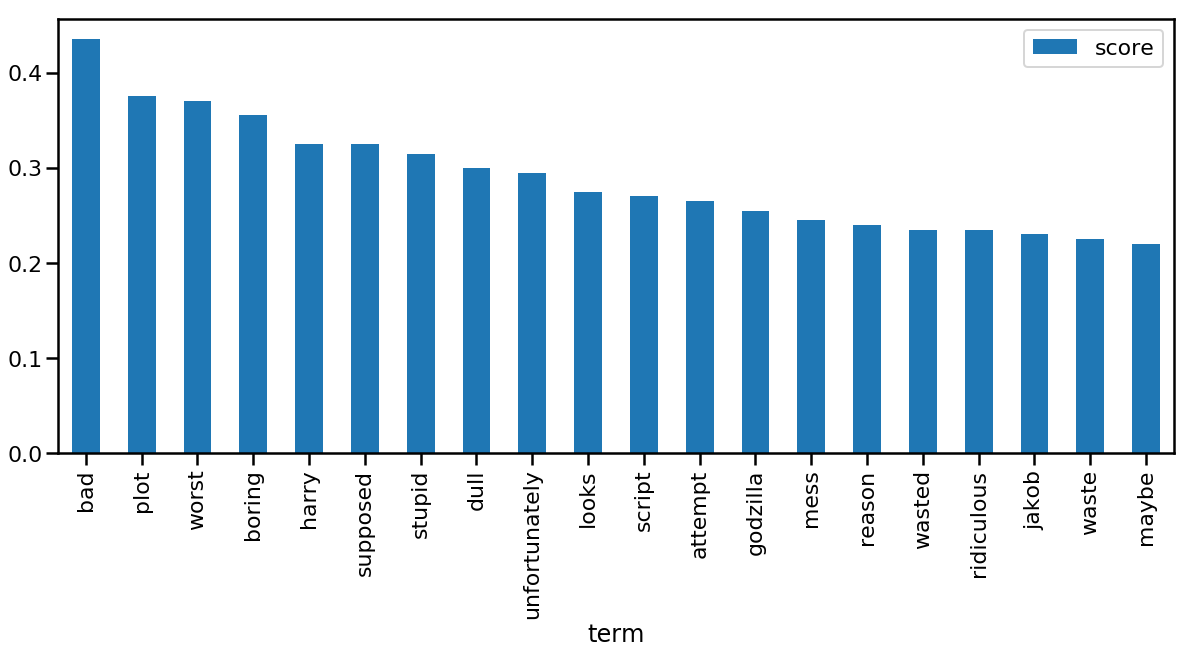

In [216]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
sb.set_context('poster')

fig, ax = plt.subplots(figsize=(20,8))
pos[:20].plot.bar(ax=ax, x='term');

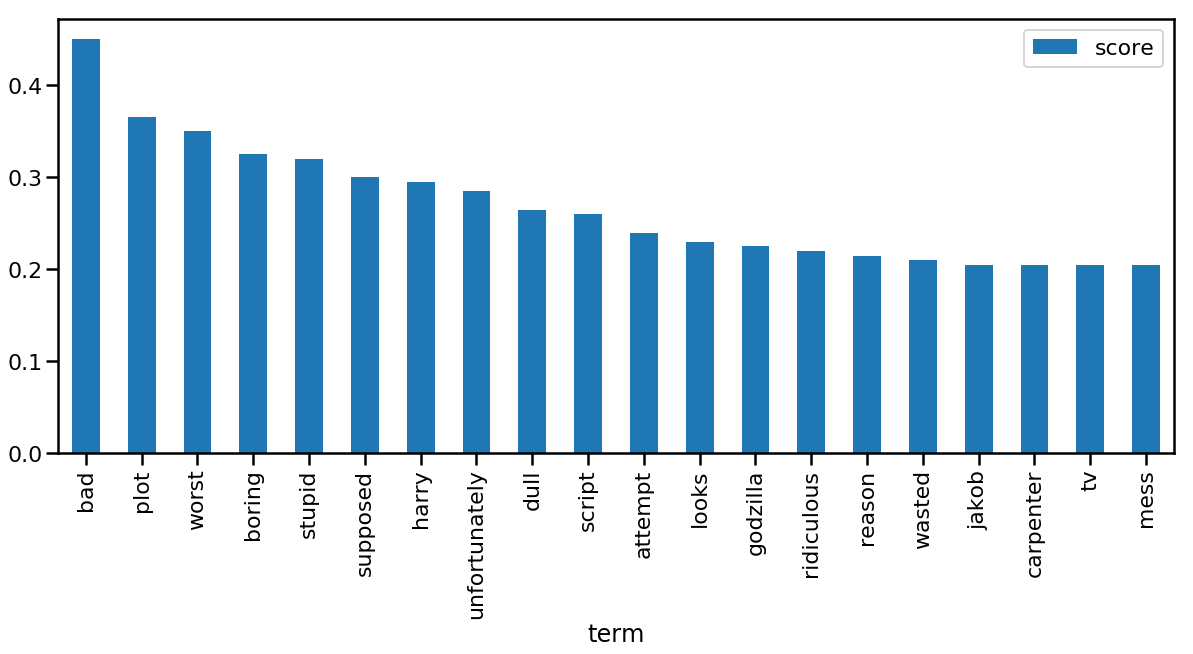

In [208]:
fig, ax = plt.subplots(figsize=(20,8))
neg[:20].plot.bar(ax=ax, x='term');

Let's use them

In [209]:
best = pos.term.tolist() + neg.term.tolist()
ids = [vectorizer.vocabulary_[i] for i in best]
X_selection = X[:, ids]

print(X_selection.shape)
print(cross_val_score(estimator=clf, X=X_selection, y=y, cv=5, scoring='f1_micro').mean())

(1800, 204)
0.8644625430065904


In [210]:
clf_RLR = LogisticRegression(solver='lbfgs', C=100)

clf_RLR.fit(X[:, ids], y)

new_predictions_RLR = clf_RLR.predict(new_X[:, ids])
print(classification_report(new_y, new_predictions_RLR))

              precision    recall  f1-score   support

           0       0.82      0.76      0.79       111
           1       0.72      0.80      0.76        89

   micro avg       0.78      0.78      0.78       200
   macro avg       0.77      0.78      0.77       200
weighted avg       0.78      0.78      0.78       200

